## Analyzing the null distribution
In Figure 2 of the paper we display a Q-Q plot comparing the theoretical (chi2) distribution against the empirical distribution of the LRT statistic. The code in this notebook demonstrates how we generated the empirical distribution, and also shows how to reproduce a Q-Q plot. 
SegCPGP is fit multiple times on data that does not contain a changepoint. Since the assumption of 'no change' in the data is our null assumption, the distribution of the LR statistic for the "changepoint" vs. "no changepoint" model should follow a $\chi^2_d$-distribution, with $d$ the difference in dimensionality between the two models.

In [1]:
import sys, os
parent_directory = os.path.abspath('..')
sys.path.append(parent_directory)
from cpgp.segcpgp import SegCPGP
import time
import numpy as np
import gpflow as gpf
import matplotlib.pyplot as plt

import pylab 
import scipy.stats as stats
import time
import tqdm
import gc 
import tensorflow as tf

2025-06-10 14:58:10.035749: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-10 14:58:10.037759: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-10 14:58:10.062920: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-10 14:58:10.062964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-10 14:58:10.063926: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
for i in tqdm.tqdm(range(0, 100)):
    X = np.arange(0, 100).reshape(-1, 1).astype(float)
    k = gpf.kernels.RBF()
    y = np.random.multivariate_normal(mean=np.zeros((len(X),)), cov=k(X))
    y += np.random.normal(0, 0.01, size=(len(X),))
    y = y.reshape(-1, 1)
    cp = SegCPGP(0.05, logging=True)
    cp.fit(X, y, "constant", verbose=False)
    with open("constant.txt", "a") as f:
        f.write(str(cp.lrts[0].numpy())+"\n")

100%|██████████| 100/100 [04:20<00:00,  2.60s/it]


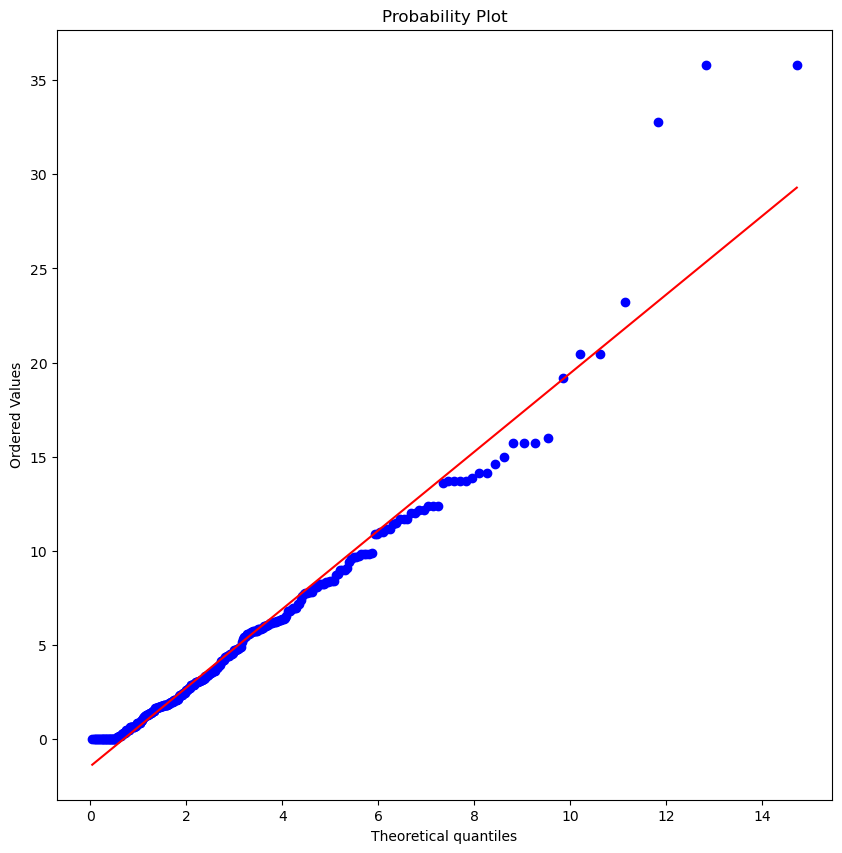

In [3]:

lrts = np.loadtxt("constant.txt")
plt.figure(figsize=(10, 10))
plt.title("chi2(3) vs. empirical LR distribution")
plt.xlabel("theoretical chi2(3) quantiles")
plt.ylabel("empirical values")
stats.probplot(lrts, dist=stats.chi2(3), plot=pylab)
pylab.show()

## Analyzing the FPR
Table 3 of the paper compares the empirical FPR against the significance level for SegCPGP. If the model is well-calibrated, the empirical FPR should remain below the significance level as the number of samples goes to infinity.

The model is fit multiple times on data containing two changes; then, classification-type metrics (FP, TP, FN, TN) are computed; from this we can compute the FPR. As the number of times we repeat this procedure grows, if our model is well calibrated, we should see that FPR $<\alpha$ (which in our case is 0.05).


In [4]:
# Alternative specification of 
def data_generating_process(kernels, N):
    for i in range(N):
        X = np.arange(80).astype(float).reshape(-1, 1)
        k = gpf.kernels.ChangePoints(kernels, locations=[20, 50], steepness=[1, 1])
        y = (np.random.multivariate_normal(np.zeros(X.shape[0]), k(X)) + np.random.normal(0, 0.1, size=X.shape[0])).reshape(-1, 1)
        yield X, y
        
def miss(locs):
    """False positive: location is not within the margins && location is detected.

    Arguments:
        locs (list) -- SegCPGP locations.

    Returns:
        fps (int): amount of false positives
    """
    fps = []
    for l in locs:
        fps.append(not 20-5 < l < 20+5 and not 50-5 < l < 50+5)
    return fps

def hit(locs):
    """True positive: location is within the margins && location is detected

    Arguments:
        locs (list) -- SegCPGP locations.

    Returns:
        tps (int): amount of true positives
    """
    tps = []
    for l in locs:
        tps.append(20-5 < l < 20+5 or 50-5 < l < 50+5)
    return tps

pval = 0.05
kernel = "rbf"

starttime = time.time()  
data = np.load(parent_directory+"/data/likelihood-ratio/likelihood-ratio-data.npz")
Xs, ys = data["Xs"], data["ys"]
alpha = pval
for i in tqdm.tqdm(range(Xs.shape[0])[:50]):  # For demonstration purposes, limit the iterations to 50
    X, y = Xs[i], ys[i]
    
    # Progress indicator 
    if i % 10 == 0:
        print(f"On iteration {i}, running {time.time() - starttime}")
    
    # Define SegCPGP 
    segcpgp = SegCPGP(alpha)
    segcpgp.fit(X, y, kernel, verbose=False)
    
    # From all the things we log in segcpgp, extract locations and pvalues
    tests = np.array([test[:3] for test in segcpgp.TESTED])
    locs = tests[:,0]
    pvals = tests[:,2]
    positives = locs[pvals<=alpha]
    negatives = locs[pvals>alpha]
    
    
    # compute relevant quantities
    FP = sum(miss(positives))
    TP = sum(hit(positives))
    TN = sum(miss(negatives))
    FN = sum(hit(negatives))
    N = len(locs)

    # Cleanup
    del X 
    del y
    del segcpgp
    tf.keras.backend.clear_session()
    gc.collect()
    with open(parent_directory + f"/data/likelihood-ratio/results_segcpgp_{alpha}.csv", "a") as myfile:
        myfile.write(f"{TP},{FP},{FN},{TN},{N}, {locs}\n")


  0%|          | 0/50 [00:00<?, ?it/s]

On iteration 0, running 0.0036306381225585938


 20%|██        | 10/50 [01:55<07:41, 11.55s/it]

On iteration 10, running 115.17364931106567


 40%|████      | 20/50 [03:49<05:41, 11.37s/it]

On iteration 20, running 229.69048857688904


 60%|██████    | 30/50 [05:47<04:06, 12.31s/it]

On iteration 30, running 347.49576115608215


 80%|████████  | 40/50 [07:46<02:06, 12.69s/it]

On iteration 40, running 466.80736017227173


100%|██████████| 50/50 [09:56<00:00, 11.94s/it]
